In [165]:
import numpy as np
import pandas as pd
from vnstock import Vnstock
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import gaussian_kde
from scipy.stats import beta, dirichlet, norm,invwishart, invgamma, beta
from scipy.special import gammaln, gamma
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import time
from datetime import datetime
from scipy import stats


# 0. OVERVIEW

In [166]:
# Load Stock Data
stock = Vnstock().stock()
ASSETS = ["HPG", "VCB", "CTG", "MSN", "MWG"]

#choose historical data of 9 stocks in 5-year period (2020-2025)
start_date = "2020-01-01"
end_date = "2025-01-01"

NUM_PORTFOLIOS = 100_000

data= pd.DataFrame()
for ticker in ASSETS:
    stock = Vnstock().stock(symbol= ticker, source='VCI')
    data[ticker] = stock.quote.history(start=start_date, end=end_date)["close"]
data = data.set_index(stock.quote.history(start=start_date, end=end_date)["time"])

2025-07-06 16:49:36 - vnstock.common.vnstock - INFO - Mã chứng khoán không được chỉ định, chương trình mặc định sử dụng VN30F1M
2025-07-06 16:49:36 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.


In [167]:
#view historical price of the portfolio
data.head()

,HPG,VCB,CTG,MSN,MWG
time,,,,,
2020-01-02,8.28,39.49,14.35,46.12,37.43
2020-01-03,8.33,39.10,14.21,46.53,36.89
2020-01-06,8.28,38.06,14.25,45.80,36.70
2020-01-07,8.17,38.19,14.48,45.96,36.99
2020-01-08,8.09,37.84,14.45,45.32,36.09


In [168]:
#calculate daily log-return
daily_log_returns = np.log(data / data.shift(1)).dropna()
mean_returns = daily_log_returns.mean()
print(mean_returns)

HPG    0.000790
VCB    0.000348
CTG    0.000775
MSN    0.000334
MWG    0.000391
dtype: float64


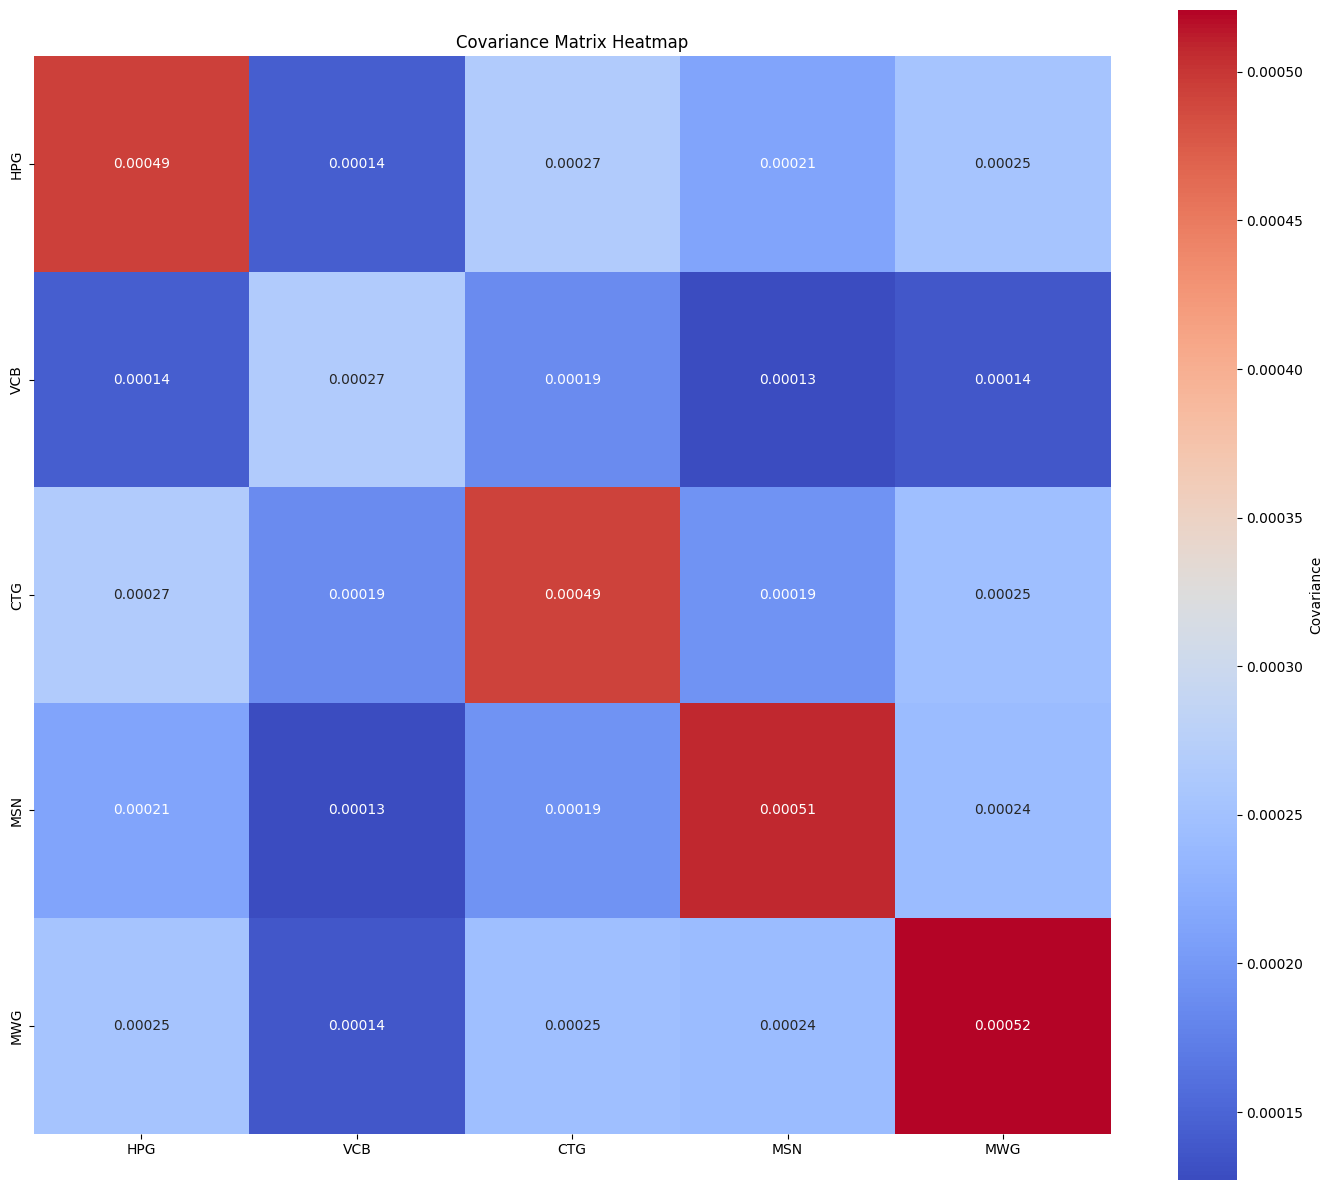

<Figure size 640x480 with 0 Axes>

In [169]:
#calculate covariance 
cov_matrix = daily_log_returns.cov()

plt.figure(figsize=(14, 12))
sns.heatmap(cov_matrix, annot=True, fmt=".5f", cmap="coolwarm", square=True, cbar_kws={"label": "Covariance"})
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
plt.show()

plt.savefig('covariance_matrix.png', dpi=300, bbox_inches='tight')


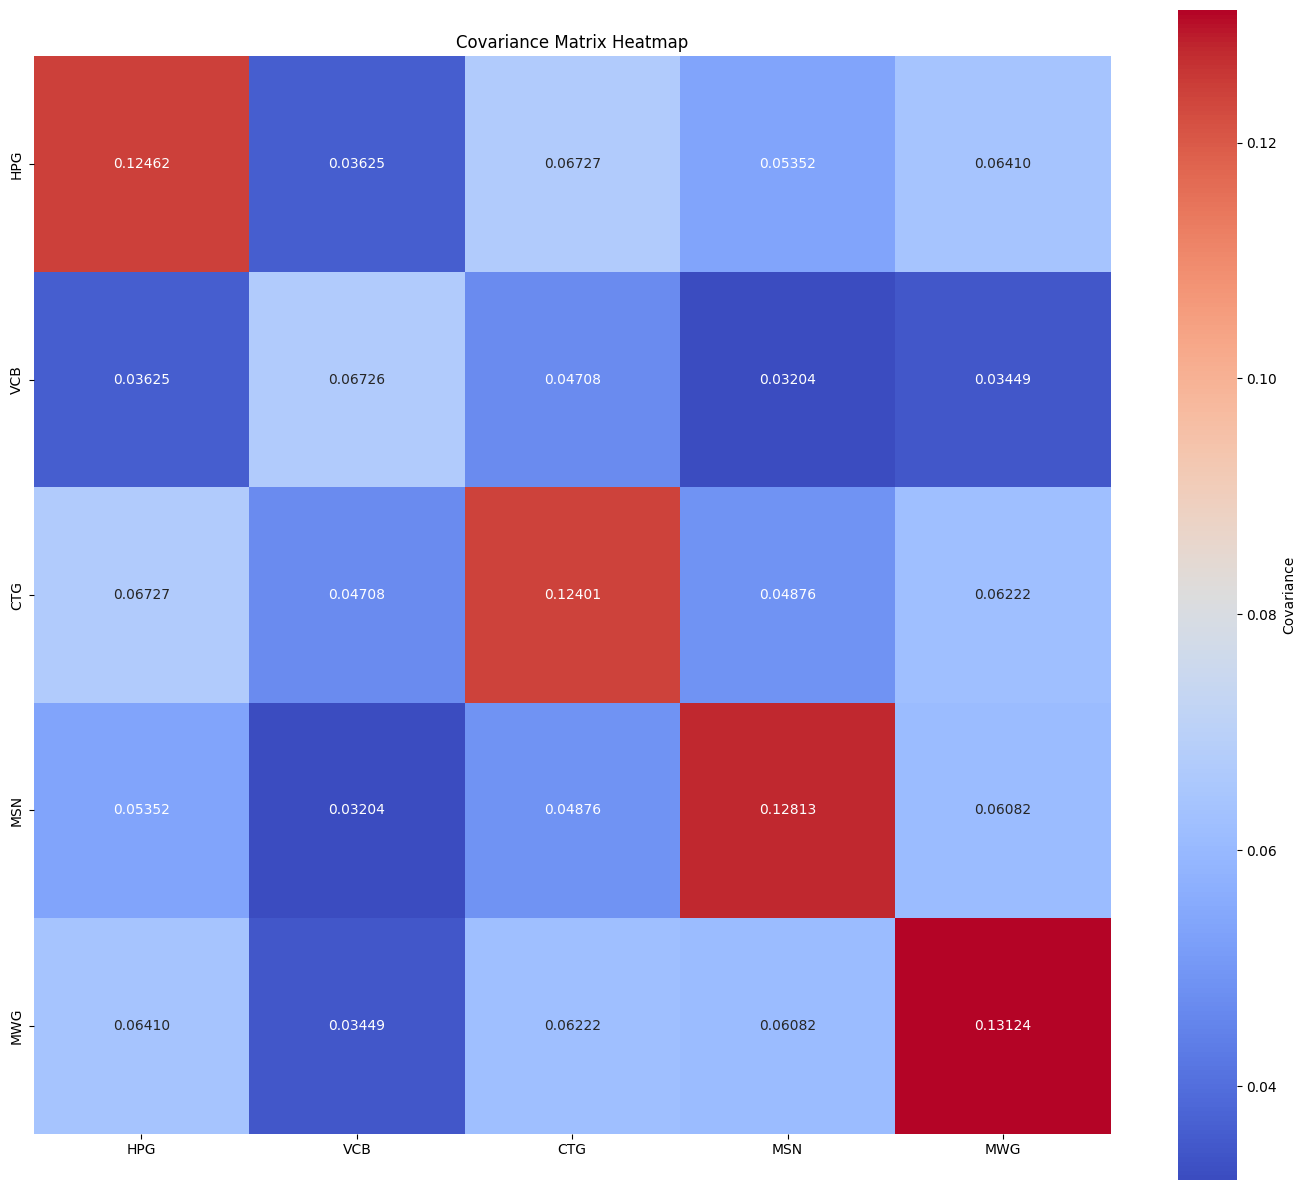

<Figure size 640x480 with 0 Axes>

In [170]:
#calculate covariance 
annual_cov_matrix = daily_log_returns.cov()*252

plt.figure(figsize=(14, 12))
sns.heatmap(annual_cov_matrix, annot=True, fmt=".5f", cmap="coolwarm", square=True, cbar_kws={"label": "Covariance"})
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
plt.show()

plt.savefig('annual_covariance_matrix.png', dpi=300, bbox_inches='tight')

In [171]:
#Loading market data (VNIndex)
MARKET = stock.listing.symbols_by_group("VN30").tolist()
MARKET = ["VNINDEX"]
MARKET_REPRESENTATION = "VNINDEX"

start_date = "2020-01-01"
end_date = "2025-01-01"

market_data= pd.DataFrame()
for ticker in MARKET:
    stock = Vnstock().stock(symbol= ticker, source='VCI')
    market_data[ticker] = stock.quote.history(start=start_date, end=end_date)["close"]
market_data = market_data.set_index(stock.quote.history(start=start_date,end=end_date)["time"])

2025-07-06 16:49:40 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.


In [172]:
RISK_FREE_RATE = 0.03

In [173]:
#view historical data of VNIndex
market_data.head()

,VNINDEX
time,
2020-01-02,966.67
2020-01-03,965.14
2020-01-06,955.79
2020-01-07,958.88
2020-01-08,948.98


In [174]:
# Calculating Market Performance (VNINDEX)
market_daily_log_returns = np.log(market_data / market_data.shift(1)).dropna() #log-price
market_return = market_daily_log_returns.mean() * 252  # Annualized return
market_volatility = market_daily_log_returns.std() * np.sqrt(252)  # Annualized volatility
market_sharpe_ratio = (market_return - RISK_FREE_RATE) / market_volatility  # Sharpe ratio
print(market_return)
print(market_volatility)
print(market_sharpe_ratio)


VNINDEX    0.054552
dtype: float64
VNINDEX    0.204193
dtype: float64
VNINDEX    0.120237
dtype: float64


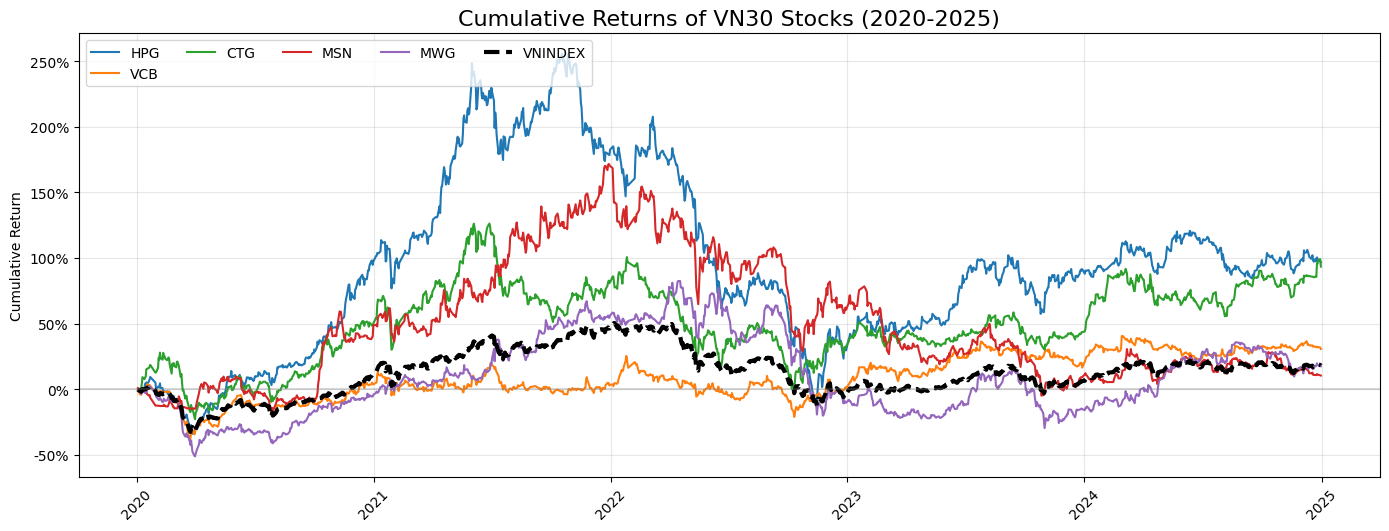

In [175]:
# Calculate cumulative returns from the beginning of 2020
cumulative_returns = (1 + daily_log_returns).cumprod() - 1
market_cumulative_returns = (1 + market_daily_log_returns).cumprod() - 1

# Create plots
plt.figure(figsize=(14, 10))

# Plot 1: Cumulative returns of all stocks from 2020-2024
plt.subplot(2, 1, 1)

# Plot individual stocks
for ticker in ASSETS:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker, linewidth=1.5)

# Plot market benchmark
plt.plot(market_cumulative_returns.index, market_cumulative_returns[MARKET_REPRESENTATION],
         label=MARKET_REPRESENTATION, linewidth=3, color='black', linestyle='--')

# Format the axis to show percentage and date properly
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
plt.xticks(rotation=45)

# Add horizontal line at 0% for reference
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

plt.title('Cumulative Returns of VN30 Stocks (2020-2025)', fontsize=16)
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', ncol=5)
plt.tight_layout()

plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')

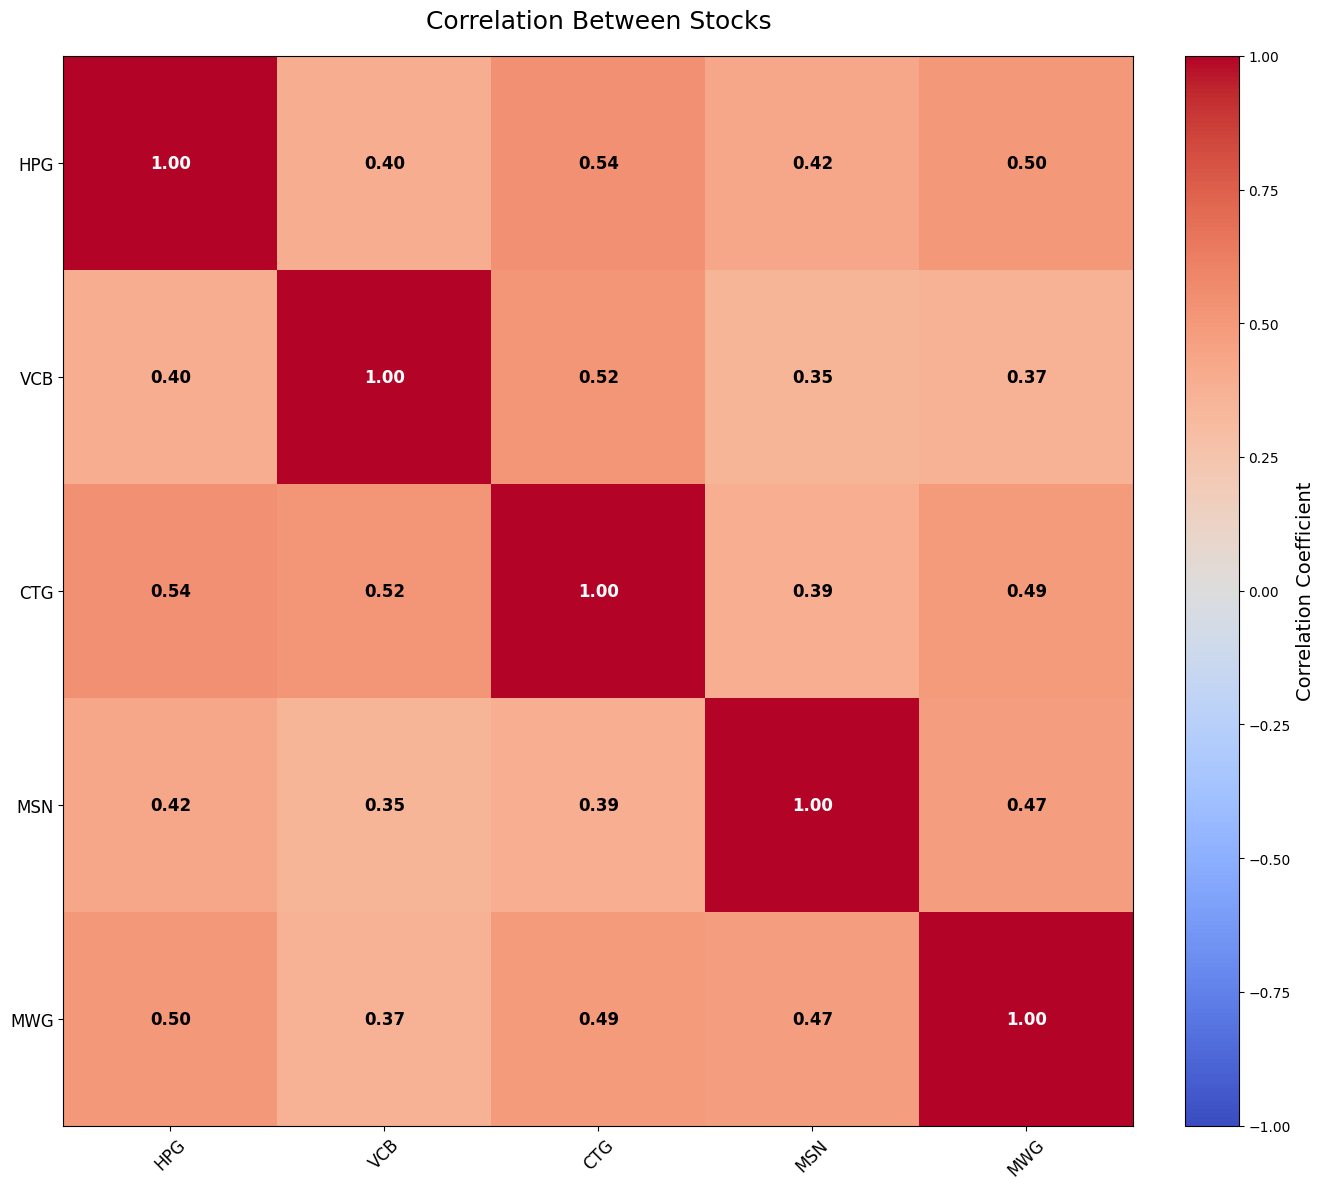

In [176]:
# create correlation bw stocks visualization
plt.figure(figsize=(14, 12))

# calculate correlation matrix
correlation_matrix = daily_log_returns.corr()

# visualize heatmap
im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontsize=14)

# Add correlation value into heatmap 
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        color = "white" if abs(correlation_matrix.iloc[i, j]) > 0.6 else "black"
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color=color, fontsize=12, fontweight='bold')

plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45, fontsize=12)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns, fontsize=12)

# Add title
plt.title('Correlation Between Stocks', fontsize=18, pad=20)

# fix layout
plt.tight_layout()

# save correlation image
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')

# display
plt.show()

# Markovwitz 

In [177]:
num_assets = len(mean_returns)
# 1. Maximum Sharpe Ratio
def negative_sharpe_ratio(weights):
    ret = np.sum(weights * mean_returns) * 252
    vol = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)
    return -(ret -RISK_FREE_RATE) / vol

constraints_maxsharpe = ({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
})

bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = np.repeat(1/num_assets, num_assets)

result_max_sharpe = minimize(
    negative_sharpe_ratio,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints_maxsharpe
)

max_sharpe_weights = result_max_sharpe.x

In [178]:
#Portfolio Performance
ret_maxsharpe = np.sum(max_sharpe_weights * mean_returns) * 252
vol_maxsharpe = np.sqrt(max_sharpe_weights.T @ cov_matrix @ max_sharpe_weights) * np.sqrt(252)
sharpe_maxsharpe = (ret_maxsharpe - RISK_FREE_RATE) / vol_maxsharpe

In [180]:
print("=== Maximum Sharpe Ratio Portfolio ===")
print("Weights:")
for i, w in enumerate(max_sharpe_weights):
    print(f"Asset {i+1}: {w:.4f}")
print(f"Expected Return: {ret_maxsharpe*100:.2f}%")
print(f"Volatility: {vol_maxsharpe*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_maxsharpe:.4f}")

=== Maximum Sharpe Ratio Portfolio ===
Weights:
Asset 1: 0.5157
Asset 2: 0.0000
Asset 3: 0.4843
Asset 4: 0.0000
Asset 5: 0.0000
Expected Return: 19.73%
Volatility: 30.96%
Sharpe Ratio: 0.5405



## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                


## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [Sổ tay hướng dẫn](https://vnstocks.com/docs/category/s%E1%BB%95-tay-h%C6%B0%E1%BB%9Bng-d%E1%BA%ABn)
* Cộng đồng: [Nhóm Facebook](https://www.facebook.com/groups/vnstock.official)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
                